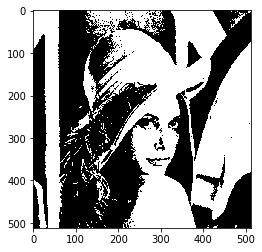

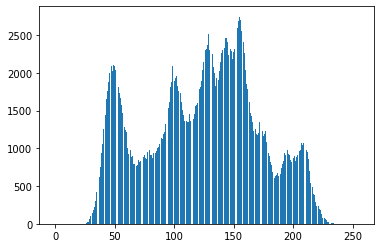

In [3]:
import cv2
import math, sys
import matplotlib.pyplot as plt

'''
savefig sould be done before show
see: https://blog.csdn.net/u010099080/article/details/52912439
'''

sys.setrecursionlimit(1000000)

####### hist part ########
def img_hist(img_in):
    hist = []
    for i in range(256):
        hist.append(0)
    
    row, col= img_in.shape
    for i in range(0, row):
        for j in range(0, col):
            hist[img_in[i, j]] += 1
    
    plt.bar(range(0, 256), hist)
    plt.savefig('histogram.png') 
    plt.show()
    return 0

####### binarize part ######
def img_binarize(img_in):
    return (img_in > 0x7f) * 0xff

########## IO ##############
img = cv2.imread('lena.bmp', 0)
img_binarized = img_binarize(img)
plt.imshow(img_binarized, cmap = 'gray')
plt.savefig('lena_binarized.png', cmap = 'gray')
plt.show()

img_hist(img)

######### CC part ##########
cc_img = (img_binarized == 0xff) * 1
parent_label = []

def union_find(label):
    original_label = label
    while label != parent_label[label]:
        label = parent_label[parent_label[label]]
        
    return label[original_label] = label
            
def connected_components():
    # set parent label
    
    plt.imshow(cc_img, cmap = 'gray')
    row, col = cc_img.shape
    for i in range(row * col):
        parent_label.append(i)

    label = 2
    for i in range(row):
        for j in range(col):   
            if j - 1 > 0 and cc_img[i, j - 1] > 1: # left has already labeled
            
    mymap = []
    for i in range(0, row * col):
        mymap.append(0)
        
    for i in range(0, row):
        for j in range(0, col):
            mymap[cc_img[i, j]] += 1
    
    #print(mymap)
    return 0

#connected_components()
#print('finished all image processing')